In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [2]:
dataset = pd.read_csv('creditcard.csv')

The dataset only contains numerical variables which have been provided to us post-PCA transformation. To maintain confidentiality, original features and data cannot be provided to us. Only two features have not been transformed via PCA. 'Time' is the amount of time that has elapsed between each transaction and the first transaction in the dataset. 'Amount' represents the transaction amount. 

Can an unsupervised algorithm (ie. isolation forest) detect the 492 fradulent transactions in the dataset? Labeled datasets are costly to produce ($, manpower, etc) and difficult to find. Let's see if an unsupervised algorithm can achieve similar results.

Text(1.2, 100000, '492')

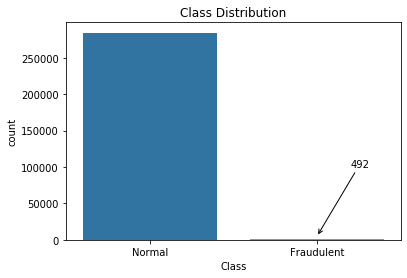

In [3]:
bars = ('Normal', 'Fraudulent')
y_pos = np.arange(2)

sns.countplot('Class', data=dataset)
plt.title('Class Distribution')
plt.xticks(y_pos, bars, horizontalalignment='center')
plt.annotate('492', xy=(1,5000), xytext=(1.2, 100000), arrowprops=dict(arrowstyle="->"))

In [4]:
print('Normal: {:.3f}%'.format(dataset['Class'].value_counts()[0]/len(dataset)*100))
print('Fradulent: {:.3f}%'.format(dataset['Class'].value_counts()[1]/len(dataset)*100))

Normal: 99.827%
Fradulent: 0.173%


## Creating our input vector (No feature engineering yet)

In [5]:
x = []
X = []
i = 0
while i < len(dataset):
    x = []
    x.append(dataset['V1'][i])
    x.append(dataset['V2'][i])
    x.append(dataset['V3'][i])
    x.append(dataset['V4'][i])
    x.append(dataset['V5'][i])
    x.append(dataset['V6'][i])
    x.append(dataset['V7'][i])
    x.append(dataset['V8'][i])
    x.append(dataset['V9'][i])
    x.append(dataset['V10'][i])
    x.append(dataset['V11'][i])
    x.append(dataset['V12'][i])
    x.append(dataset['V13'][i])
    x.append(dataset['V14'][i])
    x.append(dataset['V15'][i])
    x.append(dataset['V16'][i])
    x.append(dataset['V17'][i])
    x.append(dataset['V18'][i])
    x.append(dataset['V19'][i])
    x.append(dataset['V20'][i])
    x.append(dataset['V21'][i])
    x.append(dataset['V22'][i])
    x.append(dataset['V23'][i])
    x.append(dataset['V24'][i])
    x.append(dataset['V25'][i])
    x.append(dataset['V26'][i])
    x.append(dataset['V27'][i])
    x.append(dataset['V28'][i])
    x.append(dataset['Amount'][i])
    X.append(x)
    i += 1

Single input

In [6]:
X[0]

[-1.3598071336738,
 -0.0727811733098497,
 2.53634673796914,
 1.37815522427443,
 -0.33832076994251803,
 0.462387777762292,
 0.239598554061257,
 0.0986979012610507,
 0.363786969611213,
 0.0907941719789316,
 -0.551599533260813,
 -0.617800855762348,
 -0.991389847235408,
 -0.31116935369987897,
 1.46817697209427,
 -0.47040052525947795,
 0.20797124192924202,
 0.0257905801985591,
 0.403992960255733,
 0.251412098239705,
 -0.018306777944153,
 0.277837575558899,
 -0.110473910188767,
 0.0669280749146731,
 0.12853935827352803,
 -0.189114843888824,
 0.13355837674038698,
 -0.0210530534538215,
 149.62]

In [7]:
clf = IsolationForest(behaviour='new', n_estimators=100, contamination='auto', bootstrap=False, n_jobs=-1)
clf.fit(X)
y_pred = clf.predict(X)

Convert labels from -1, 1, to 1, 0. (1=anomalous, 0='normal')

In [8]:
labels = []
for i in y_pred:
    if i == 1:
        i = 0
    if i == -1:
        i = 1
    labels.append(i)

Adding the list of isoForest labels to our original dataframe

In [9]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
dataset['isoForest_labels'] = labels

Great, let's compare! How many anomalies did our isoForest detect?

In [16]:
isodata_counts = dataset['isoForest_labels'].value_counts()

In [20]:
print('Our unsupervised method detected ' + str(isodata_counts[1]) + ' anomalies compared to the actual number of 492.') 

Our unsupervised method detected 10478 anomalies compared to the actual number of 492.


Text(1.2, 100000, '10478')

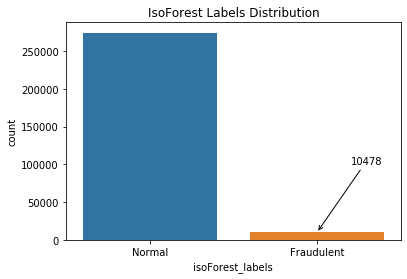

In [17]:
bars = ('Normal', 'Fraudulent')
y_pos = np.arange(2)

sns.countplot('isoForest_labels', data=dataset)
plt.title('IsoForest Labels Distribution')
plt.xticks(y_pos, bars, horizontalalignment='center')
plt.annotate(str(isodata_counts[1]), xy=(1,10000), xytext=(1.2, 100000), arrowprops=dict(arrowstyle="->"))

Are the actual anomalies even detected with the isoForest? Let's check by isolating only the fradulent instances. 

In [13]:
fraud_data = dataset[dataset['Class'] == 1].reset_index()
iso_forest_counts = fraud_data['isoForest_labels'].value_counts()

In [24]:
print('The isolation forest correctly identified ' + str(iso_forest_counts[1]) + ' instances of fraud.')
print('Unfortunately, it incorrectly classified ' + str(iso_forest_counts[0]) + ' fradulent instances as normal.')
print('Not to mention, the model incorrectly identified ' + str(isodata_counts[1] - 492) + ' normal intstances as fraudulent.')

The isolation forest correctly identified 404 instances of fraud.
Unfortunately, it incorrectly classified 88 fradulent instances as normal.
Not to mention, the model incorrectly identified 9986 normal intstances as fraudulent.
